In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.activations import linear, relu, sigmoid

from datasets import load_dataset

import matplotlib.pyplot as plt

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

np.set_printoptions(precision=2)

# **Load Dataset**

In [46]:
ds = load_dataset("keremberke/chest-xray-classification", name="full")

In [47]:
X = ds['train']
y = ds['validation']

In [48]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4077
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1165
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 582
    })
})


# **Preprocess Data**

In [49]:
from PIL import Image
import numpy as np

# Define a function to preprocess an image for CNN input
def preprocess_image(image_path):
    # Open and resize the image to 50x50 pixels
    image = Image.open(image_path).resize((50, 50))
    # Convert to grayscale
    image = image.convert('L')
    # Convert to NumPy array and reshape to (50, 50, 1)
    image_array = np.array(image).reshape((50, 50, 1))
    # Normalize pixel values to the range [0, 1]
    image_array = image_array / 255.0
    return image_array

# Create empty arrays to store the data and labels
X_train = np.empty((4077, 50, 50, 1), dtype=np.float32)
X_validation = np.empty((1165, 50, 50, 1), dtype=np.float32)
X_test = np.empty((582, 50, 50, 1), dtype=np.float32)

y_train = np.empty((4077,), dtype=np.int32)
y_validation = np.empty((1165,), dtype=np.int32)
y_test = np.empty((582,), dtype=np.int32)

# Iterate through your dataset, preprocess each image, and extract labels
for i, example in enumerate(ds['train']):
    image_path = example['image_file_path']
    image_array = preprocess_image(image_path)
    X_train[i] = image_array
    y_train[i] = example['labels']

for i, example in enumerate(ds['validation']):
    image_path = example['image_file_path']
    image_array = preprocess_image(image_path)
    X_validation[i] = image_array
    y_validation[i] = example['labels']

for i, example in enumerate(ds['test']):
    image_path = example['image_file_path']
    image_array = preprocess_image(image_path)
    X_test[i] = image_array
    y_test[i] = example['labels']


In [50]:
X_train[0]

array([[[0.11],
        [0.24],
        [0.45],
        ...,
        [0.55],
        [0.51],
        [0.44]],

       [[0.11],
        [0.21],
        [0.44],
        ...,
        [0.58],
        [0.51],
        [0.42]],

       [[0.11],
        [0.17],
        [0.4 ],
        ...,
        [0.58],
        [0.51],
        [0.4 ]],

       ...,

       [[0.15],
        [0.16],
        [0.16],
        ...,
        [0.12],
        [0.13],
        [0.12]],

       [[0.15],
        [0.16],
        [0.16],
        ...,
        [0.12],
        [0.13],
        [0.13]],

       [[0.15],
        [0.16],
        [0.16],
        ...,
        [0.12],
        [0.13],
        [0.12]]], dtype=float32)

In [51]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

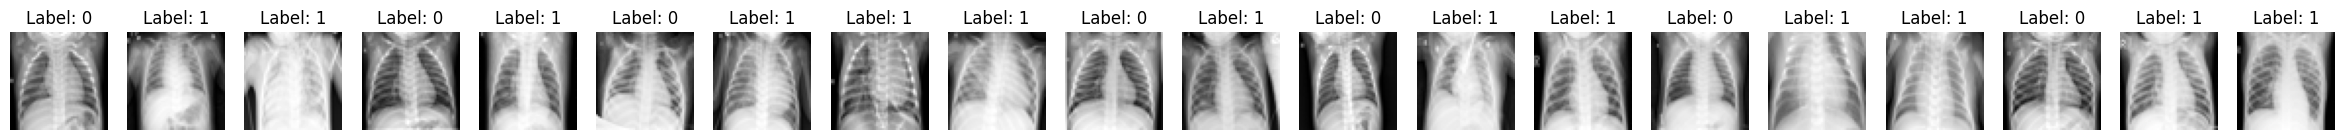

In [52]:
import random

# Define a function to visualize a random subset of the data
def visualize_random_data(images, labels, num_samples):
    num_total_samples = len(images)
    random_indices = random.sample(range(num_total_samples), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(30, 2))
    for i, idx in enumerate(random_indices):
        ax = axes[i]
        ax.imshow(images[idx].reshape(50, 50), cmap='gray')
        ax.set_title(f"Label: {labels[idx]}")
        ax.axis('off')
    plt.show()

# Visualize a random subset of your training data
num_samples_to_visualize = 20
visualize_random_data(X_train, y_train, num_samples_to_visualize)


# **Neural Networks**

In [53]:
tf.random.set_seed(64)
model = Sequential(
    [
        Conv2D(64, (3, 3), activation='relu', input_shape=(50, 50 ,1)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(256, activation='relu', name='L1'),
        Dense(150, activation='relu', name='L2'),
        Dense(64, activation='relu', name='L3'),
        Dense(32, activation='relu', name='L4'),
        Dense(16, activation='relu', name='L5'),
        Dense(2, activation='linear', name='L6')
    ], name = "my_model"
)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']  # Add accuracy as a metric for monitoring
)

# Train your model and store the training history
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_validation, y_validation)  # Use validation data for monitoring
)

Epoch 1/50
128/128 [==============================] - 10s 71ms/step - loss: 0.4071 - accuracy: 0.8035 - val_loss: 0.1646 - val_accuracy: 0.9313
Epoch 2/50
128/128 [==============================] - 9s 72ms/step - loss: 0.1822 - accuracy: 0.9316 - val_loss: 0.1590 - val_accuracy: 0.9373
Epoch 3/50
128/128 [==============================] - 9s 72ms/step - loss: 0.1557 - accuracy: 0.9441 - val_loss: 0.1164 - val_accuracy: 0.9545
Epoch 4/50
128/128 [==============================] - 9s 72ms/step - loss: 0.1512 - accuracy: 0.9438 - val_loss: 0.2271 - val_accuracy: 0.9142
Epoch 5/50
128/128 [==============================] - 9s 72ms/step - loss: 0.1415 - accuracy: 0.9482 - val_loss: 0.1199 - val_accuracy: 0.9528
Epoch 6/50
128/128 [==============================] - 9s 74ms/step - loss: 0.1201 - accuracy: 0.9551 - val_loss: 0.1128 - val_accuracy: 0.9597
Epoch 7/50
128/128 [==============================] - 9s 71ms/step - loss: 0.1061 - accuracy: 0.9620 - val_loss: 0.1177 - val_accuracy: 0.958

In [54]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 22, 22, 64)        36928     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 11, 11, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 7744)              0         
                                                                 
 L1 (Dense)                  (None, 256)               198

In [55]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 0s 15ms/step - loss: 0.7639 - accuracy: 0.9416


[0.7639173865318298, 0.9415807723999023]

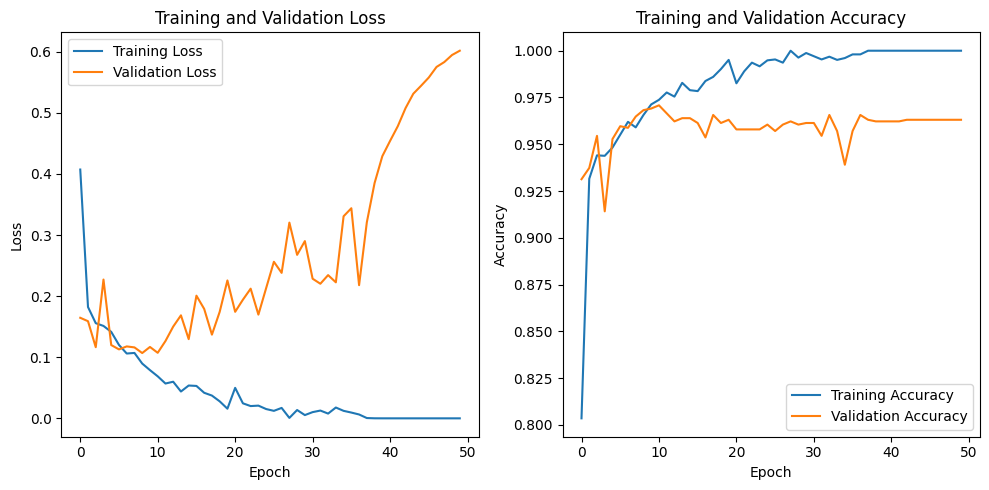

In [56]:
# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



19/19 [==============================] - 0s 14ms/step


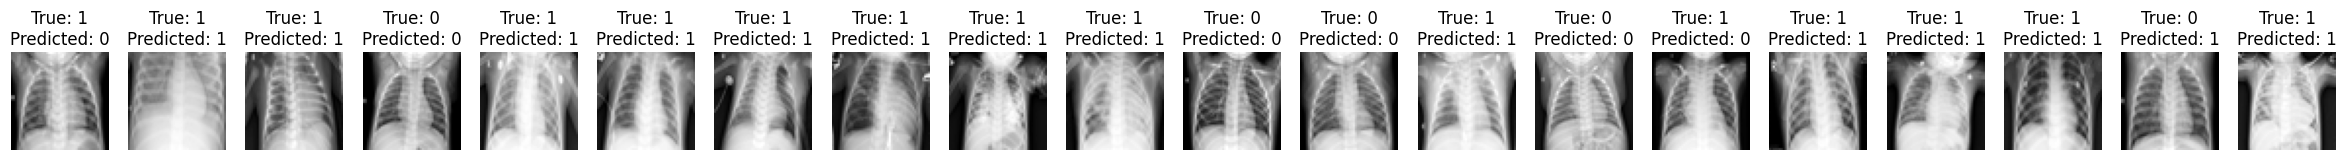

In [57]:
import matplotlib.pyplot as plt
import random

# Make predictions using your model on the test data
# Replace 'model' with the actual name of your trained model
predictions = model.predict(X_test)

# Define a function to visualize the results
def visualize_results(images, true_labels, predicted_labels, num_samples):
    random_indices = random.sample(range(len(images)), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(30, 2))
    for i, idx in enumerate(random_indices):
        ax = axes[i]
        ax.imshow(images[idx].reshape(50, 50), cmap='gray')
        true_label = true_labels[idx]
        predicted_label = predicted_labels[idx]
        ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}")
        ax.axis('off')
    plt.show()

# Visualize a random subset of test data along with their true and predicted labels
num_samples_to_visualize = 20
visualize_results(X_test, y_test, predictions.argmax(axis=1), num_samples_to_visualize)


19/19 [==============================] - 0s 14ms/step


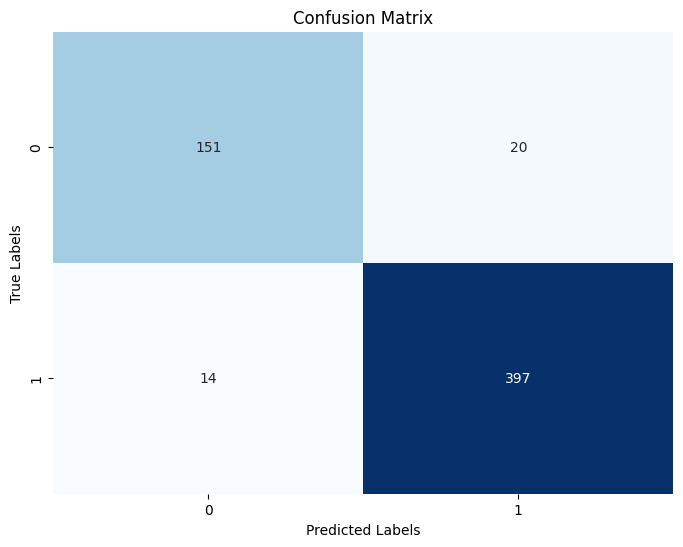

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
